# Point Source Fluxes and Multiple Sources

Once one has computed a spectral to a point source, getting the flux of that source is possible.
In 3ML, we can obtain flux in a variety of units in a live analysis or from saved fits. There is no need to know exactly what you want to obtain at the time you do the fit.

Also, let's explore how to deal with fitting multiple point sources and linking of parameters.


Let's explore the possibilites.



In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")
import astropy.units as u
from threeML import *
from threeML.utils.OGIP.response import OGIPResponse
from threeML.io.package_data import get_path_of_data_file

In [3]:
from jupyterthemes import jtplot

%matplotlib inline
jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
silence_warnings()
set_threeML_style()

## Generating some synthetic data

![alt text](http://aasnova.org/wp-content/uploads/2016/03/fig16.jpg)

Let's say we have two galactic x-ray sources, some accreting compact binaries perhaps? We observe them at two different times. These sources (imaginary) sources emit a blackbody which is theorized to always be at the same temperature, but perhaps at different flux levels.


Lets simulate one of these sources:


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


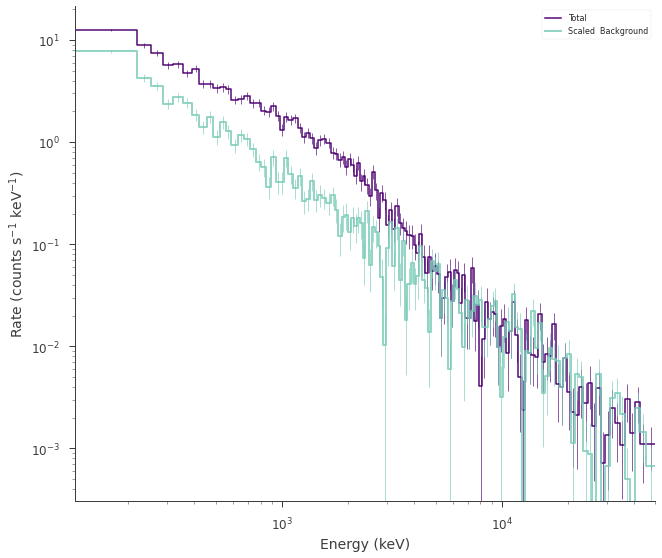

In [4]:
np.random.seed(1234)

# we will use a demo response
response_1 = OGIPResponse(get_path_of_data_file("datasets/ogip_powerlaw.rsp"))


source_function_1 = Blackbody(K=5e-8, kT=500.0)
background_function_1 = Powerlaw(K=1, index=-1.5, piv=1.0e3)


spectrum_generator_1 = DispersionSpectrumLike.from_function(
    "s1",
    source_function=source_function_1,
    background_function=background_function_1,
    response=response_1,
)

fig = spectrum_generator_1.view_count_spectrum()

Now let's simulate the other source, but this one has an extra feature! There is a power law component in addition to the blackbody.

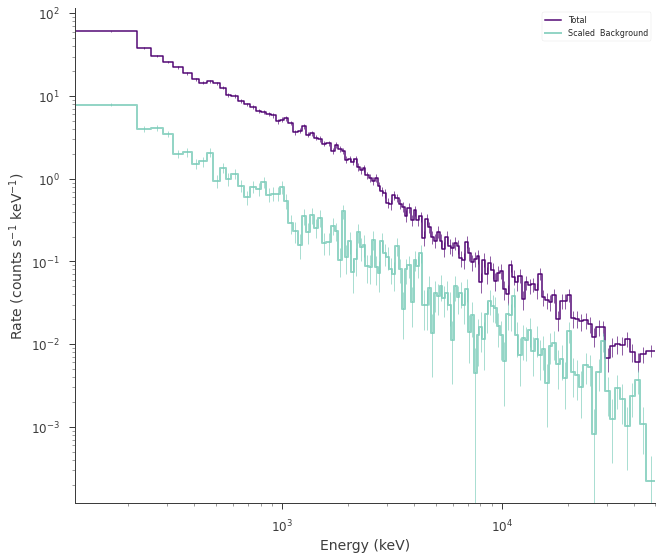

In [5]:

response_2 = OGIPResponse(get_path_of_data_file("datasets/ogip_powerlaw.rsp"))


source_function_2 = Blackbody(K=1e-7, kT=500.0) + Powerlaw_flux(
    F=2e2, index=-1.5, a=10, b=500
)
background_function_2 = Powerlaw(K=1, index=-1.5, piv=1.0e3)


spectrum_generator_2 = DispersionSpectrumLike.from_function(
    "s2",
    source_function=source_function_2,
    background_function=background_function_2,
    response=response_2,
)

fig = spectrum_generator_2.view_count_spectrum()

## Make the model

Now let's make the model we will use to fit the data. First, let's make the spectral function for source_1 and set priors on the parameters.


In [6]:
spectrum_1 = Blackbody()

spectrum_1.K.prior = Log_normal(mu=np.log(1e-7), sigma=1)
spectrum_1.kT.prior = Log_normal(mu=np.log(300), sigma=2)

ps1 = PointSource("src1", ra=1, dec=20, spectral_shape=spectrum_1)

We will do the same for the other source but also include the power law component

In [7]:
spectrum_2 = Blackbody() + Powerlaw_flux(
    a=10, b=500
)  # a,b are the bounds for the flux for this model

spectrum_2.K_1.prior = Log_normal(mu=np.log(1e-6), sigma=1)
spectrum_2.kT_1.prior = Log_normal(mu=np.log(300), sigma=2)

spectrum_2.F_2.prior = Log_normal(mu=np.log(1e2), sigma=1)
spectrum_2.F_2.bounds = (None, None)

spectrum_2.index_2.prior = Gaussian(mu=-1.0, sigma=1)
spectrum_2.index_2.bounds = (None, None)

ps2 = PointSource("src2", ra=2, dec=-10, spectral_shape=spectrum_2)

Now we can combine these two sources into our model.

In [8]:
model = Model(ps1, ps2)

### Linking parameters

We hypothesized that both sources should have the a same blackbody temperature. We can impose this by linking the temperatures.


In [9]:
model.link(
    model.src1.spectrum.main.Blackbody.kT, model.src2.spectrum.main.composite.kT_1
)

we could also link the parameters with an arbitrary function rather than directly. Check out the [astromodels documentation](https://astromodels.readthedocs.io/en/latest/Model_tutorial.html#linking-parameters) for more details.

In [10]:
model

Model summary:
==============

                  N
Point sources     2
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                       value min_value max_value  \
src1.spectrum.main.Blackbody.K        0.0001       0.0      None   
src2.spectrum.main.composite.K_1      0.0001       0.0      None   
src2.spectrum.main.composite.kT_1       30.0       0.0      None   
src2.spectrum.main.composite.F_2         1.0       0.0      None   
src2.spectrum.main.composite.index_2    -2.0      None      None   

                                                unit  
src1.spectrum.main.Blackbody.K        s-1 cm-2 keV-3  
src2.spectrum.main.composite.K_1      s-1 cm-2 keV-3  
src2.spectrum.main.composite.kT_1                keV  
src2.spectrum.main.composite.F_2            s-1 cm-2  
src2.spectrum.main.composite.index_2                  

Fixed parameters (8):
(abridged. Use complete=True to see all fixed parameters)


Linked parameters (1):
----------------------

                 src1.spectrum.main.Blackbody.kT
current value                               30.0
function                                    Line
linked to      src2.spectrum.main.composite.kT_1
unit                                         keV


Independent variables:
----------------------

(none)

### Assigning sources to plugins

Now, if we simply passed out model to the BayesianAnalysis or JointLikelihood objects, it would sum the point source spectra together and apply both sources to all data.

This is not what we want. Many plugins have the ability to be assigned directly to a source. Let's do that here:

In [11]:
spectrum_generator_1.assign_to_source("src1")

spectrum_generator_2.assign_to_source("src2")

Now we simply make our our data list

In [12]:
data = DataList(spectrum_generator_1, spectrum_generator_2)

## Fitting the data

Now we fit the data as we normally would. We use Bayesian analysis here.

In [13]:
ba = BayesianAnalysis(model, data)
ba.set_sampler("ultranest")
ba.sampler.setup(frac_remain=0.5)
_ = ba.sample()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+03  


[ultranest] Likelihood function evaluations: 84042


[ultranest]   logZ = -1340 +- 0.1486


[ultranest] Effective samples strategy satisfied (ESS = 957.9, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.36, need <0.5)


[ultranest]   logZ error budget: single: 0.23 bs:0.15 tail:0.41 total:0.43 required:<0.50


[ultranest] done iterating.


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
src1.spectrum.main.Blackbody.K,(4.68 +/- 0.28) x 10^-8,1 / (cm2 keV3 s)
src2.spectrum.main.composite.K_1,(9.7 +/- 0.6) x 10^-8,1 / (cm2 keV3 s)
src2.spectrum.main.composite.kT_1,(5.10 +/- 0.09) x 10^2,keV
src2.spectrum.main.composite.F_2,(2.06 +/- 0.08) x 10^2,1 / (cm2 s)
src2.spectrum.main.composite.index_2,-1.511 +/- 0.010,



Values of -log(posterior) at the minimum:



,-log(posterior)
s1,-604.940684
s2,-699.302962
total,-1304.243646



Values of statistical measures:



,statistical measures
AIC,2618.727291
BIC,2636.213178
DIC,2628.729631
PDIC,4.751921
log(Z),-581.792696


Let's examine the fits.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


(1e-06, 3488.0616106230545)

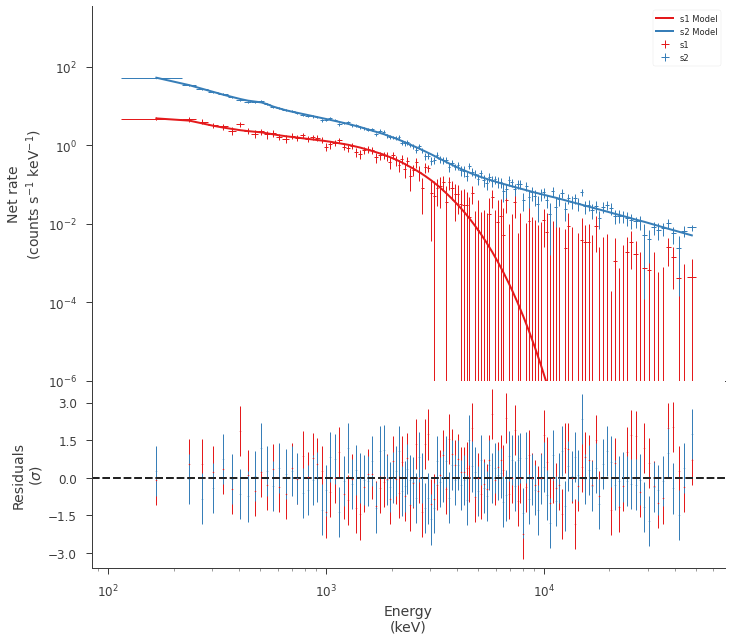

In [14]:
fig = display_spectrum_model_counts(ba)
ax = fig.get_axes()[0]
ax.set_ylim(1e-6)

Lets grab the result. Remember, we can save the results to disk, so all of the following operations can be run at a later time without having to redo all the above steps!

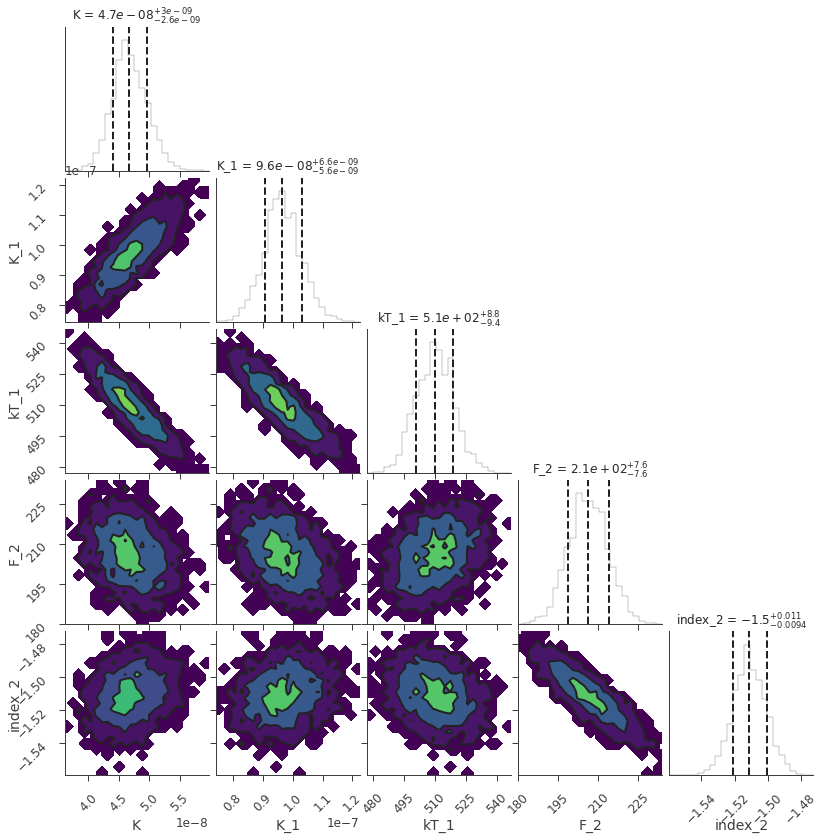

In [15]:
result = ba.results
fig = result.corner_plot()

## Computing fluxes

Now we will compute fluxes. We can compute them an many different units, over any energy range also specified in any units.

The flux is computed by integrating the function over energy. By default, a fast trapezoid method is used. If you need more accuracy, you can change the method in the configuration.


In [16]:
threeML_config.point_source.integrate_flux_method = "quad"

result.get_flux(ene_min=1 * u.keV, ene_max=1 * u.MeV, flux_unit="erg/cm2/s")

processing Bayesian analyses:   0%|          | 0/2 [00:00<?, ?it/s]

,flux,low bound,hi bound
src1: total,5.710579326366326e-06 erg / (cm2 s),5.3836551371374235e-06 erg / (cm2 s),6.074574393889567e-06 erg / (cm2 s)
src2: total,4.8490461195829314e-05 erg / (cm2 s),4.6854428449470464e-05 erg / (cm2 s),5.024187218458445e-05 erg / (cm2 s)


We see that a pandas dataframe is returned with all the information. We could change the confidence region for the uncertainties if we desire. However, we could also sum the source fluxes! 3ML will take care of propagating the uncertainties (for any of these operations).

In [17]:
threeML_config.point_source.integrate_flux_method = "trapz"

result.get_flux(
    ene_min=1 * u.keV,
    ene_max=1 * u.MeV,
    confidence_level=0.95,
    sum_sources=True,
    flux_unit="erg/cm2/s",
)

processing Bayesian analyses:   0%|          | 0/2 [00:00<?, ?it/s]

,flux,low bound,hi bound
total,5.4260592999929365e-05 erg / (cm2 s),5.104898697313528e-05 erg / (cm2 s),5.773712931198162e-05 erg / (cm2 s)


We can get the fluxes of individual components:

In [18]:
result.get_flux(
    ene_min=10 * u.keV, ene_max=0.5 * u.MeV, use_components=True, flux_unit="1/(cm2 s)"
)

processing Bayesian analyses:   0%|          | 0/2 [00:00<?, ?it/s]

,flux,low bound,hi bound
src1: total,2.1177745198119027 1 / (cm2 s),1.9964338080259343 1 / (cm2 s),2.2508625606845025 1 / (cm2 s)
src2: Blackbody,4.3727409003913955 1 / (cm2 s),4.099286691620605 1 / (cm2 s),4.683115178247504 1 / (cm2 s)
src2: Powerlaw_flux,219.86990857249265 1 / (cm2 s),211.88562130060913 1 / (cm2 s),227.77418858078371 1 / (cm2 s)


As well as choose which component to compute

In [19]:
result.get_flux(
    ene_min=10 * u.keV,
    ene_max=0.5 * u.MeV,
    use_components=True,
    components_to_use=["Blackbody"],
    flux_unit="erg2/(cm2 s)",
)

processing Bayesian analyses:   0%|          | 0/2 [00:00<?, ?it/s]

,flux,low bound,hi bound
src1: total,6.299952992722166e-13 erg2 / (cm2 s),5.939603125972576e-13 erg2 / (cm2 s),6.707380186700358e-13 erg2 / (cm2 s)
src2: Blackbody,1.3038893346208992e-12 erg2 / (cm2 s),1.2191118370628297e-12 erg2 / (cm2 s),1.3977806981177107e-12 erg2 / (cm2 s)


Finally, the returned flux object is a pandas table and can be manipulated as such:

In [20]:
flux = result.get_flux(ene_min=1 * u.keV, ene_max=1 * u.MeV, flux_unit="erg/cm2/s")

processing Bayesian analyses:   0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
flux["flux"]

src1: total     5.692836819850656e-06 erg / (cm2 s)
src2: total    4.8542861132191444e-05 erg / (cm2 s)
Name: flux, dtype: object

In [22]:
flux["flux"]["src1: total"]

<Quantity 5.69283682e-06 erg / (cm2 s)>